In [ ]:
############################## Convert images to .npy file ####################################
from PIL import Image
import os, sys
# import cv2
import numpy as np

path = "/home/laurens/IDL/data/2/"
dirs = os.listdir( path )
dirs.sort()
x_train=[]

def load_convert_dataset():
    # Append images to a list
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert("RGB")
            im = np.array(im)
            x_train.append(im)
    imgset=np.array(x_train)
    np.save(path+'tiny_heroes.npy', x_train)


load_convert_dataset()

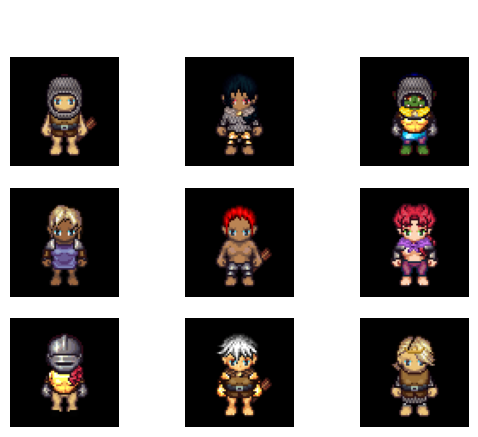

In [2]:
########################### Load dataset ######################################################
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

def load_real_samples(scale=False):
    # X = np.load('/content/face_dataset_64x64.npy',  fix_imports=True,encoding='latin1')[:20000, :, :, :]
    X = np.load('/content/tiny_heroes.npy',  fix_imports=True,encoding='latin1')[:, :, :, :]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
# grid_plot(dataset[np.random.randint(0, 1000, 9)], name='Fliqr dataset (64x64x3)', n=3)
grid_plot(dataset[np.random.randint(0, 1000, 9)], n=3)

In [3]:
########################################## (DE)Convolutional Nets ##############################################
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

In [4]:
################################################## VAE #############################################

class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                3

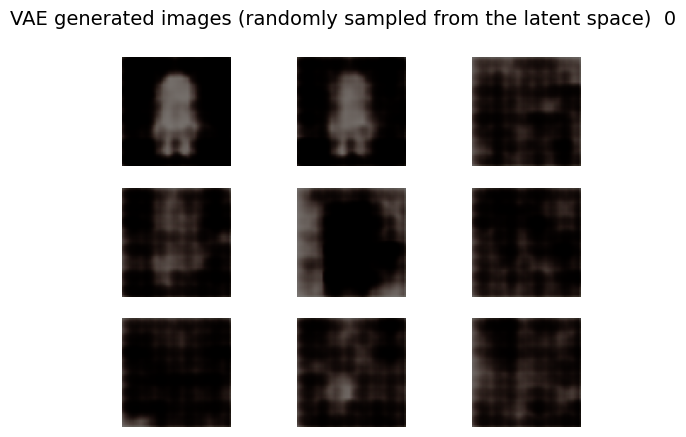

114/114 [==============================] - 1s 11ms/step - loss: 0.1682


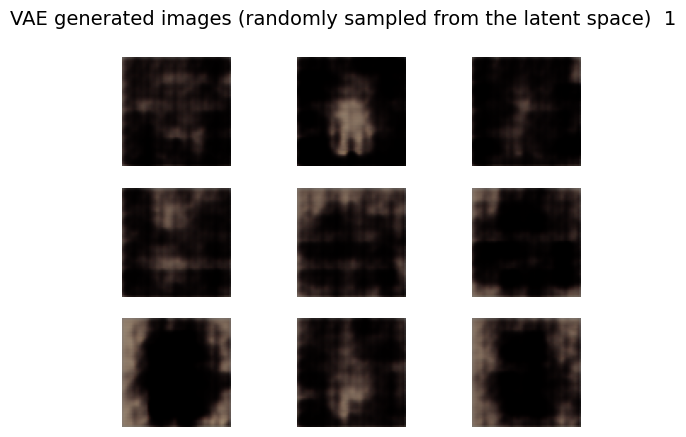

114/114 [==============================] - 1s 11ms/step - loss: 0.1645


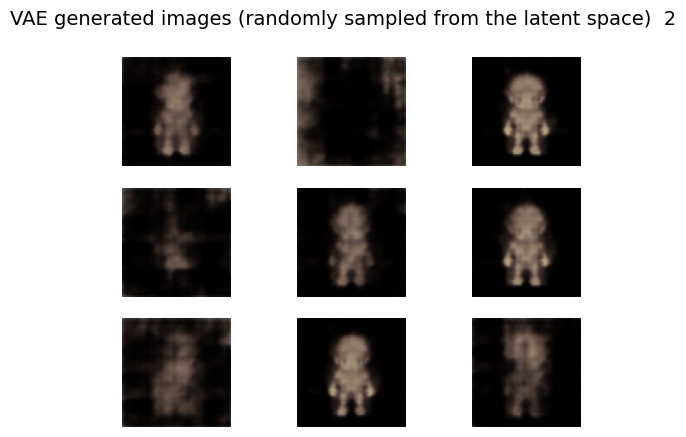

114/114 [==============================] - 1s 11ms/step - loss: 0.1617


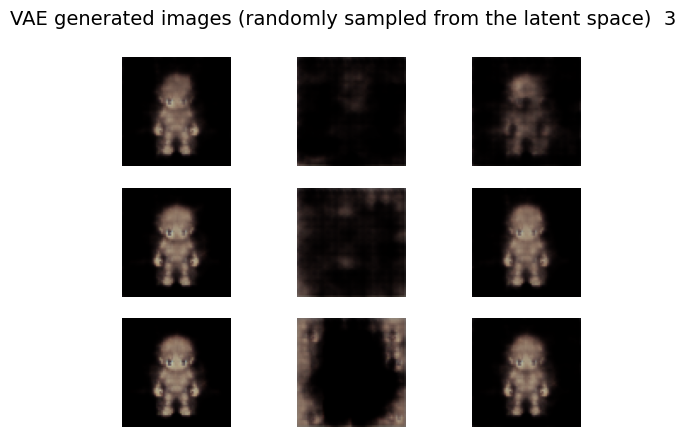

114/114 [==============================] - 1s 12ms/step - loss: 0.1611


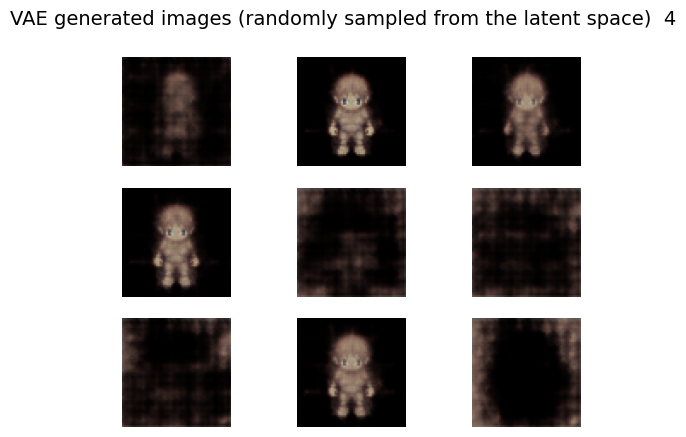

114/114 [==============================] - 1s 11ms/step - loss: 0.1601


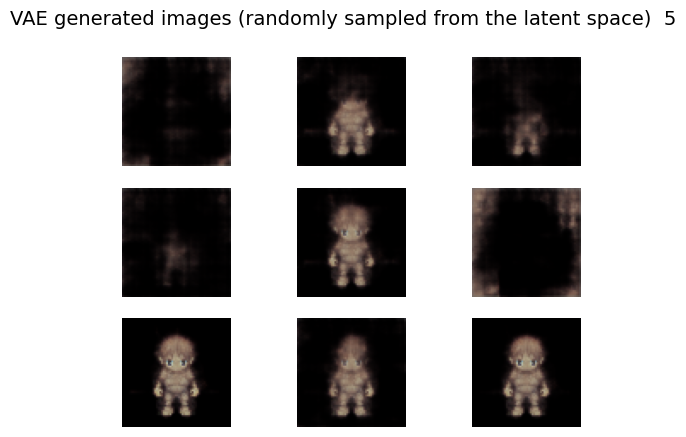

114/114 [==============================] - 1s 11ms/step - loss: 0.1596


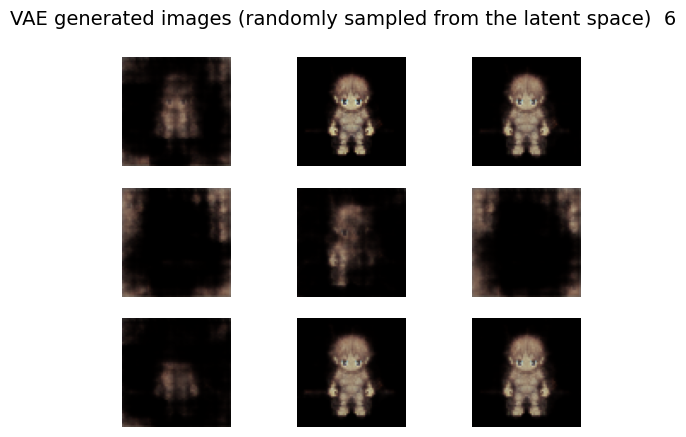

114/114 [==============================] - 1s 12ms/step - loss: 0.1594


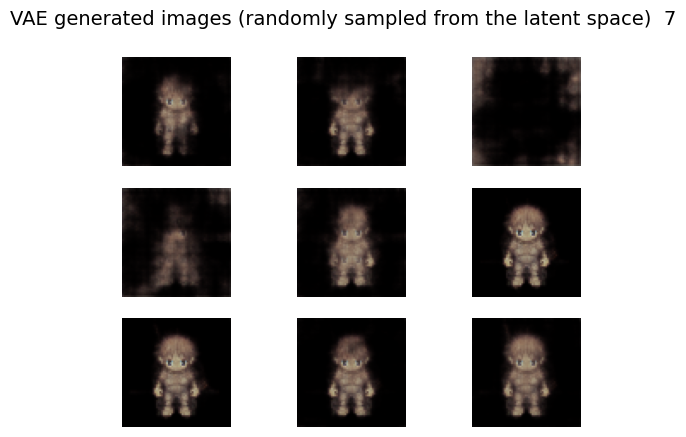

114/114 [==============================] - 2s 14ms/step - loss: 0.1589


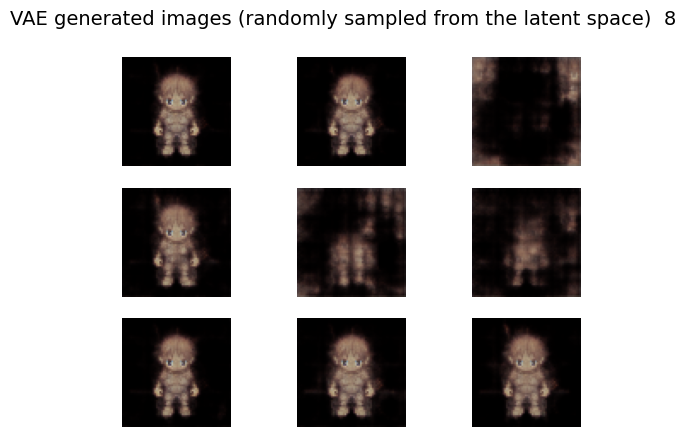

114/114 [==============================] - 1s 12ms/step - loss: 0.1593


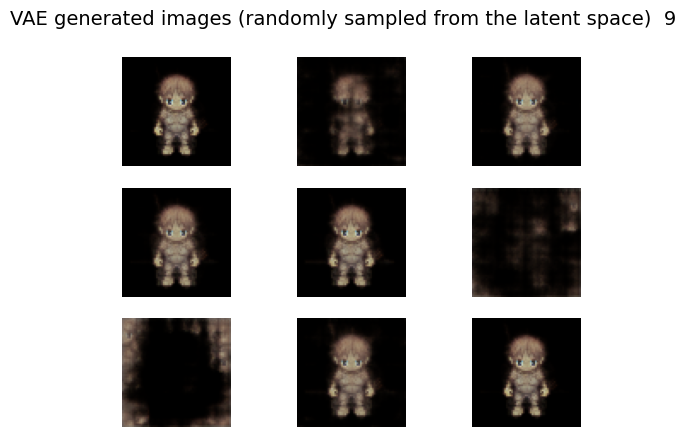

114/114 [==============================] - 1s 12ms/step - loss: 0.1582


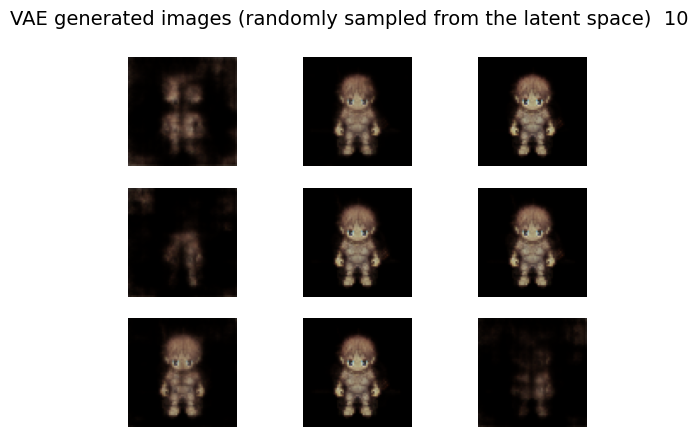

114/114 [==============================] - 2s 17ms/step - loss: 0.1578


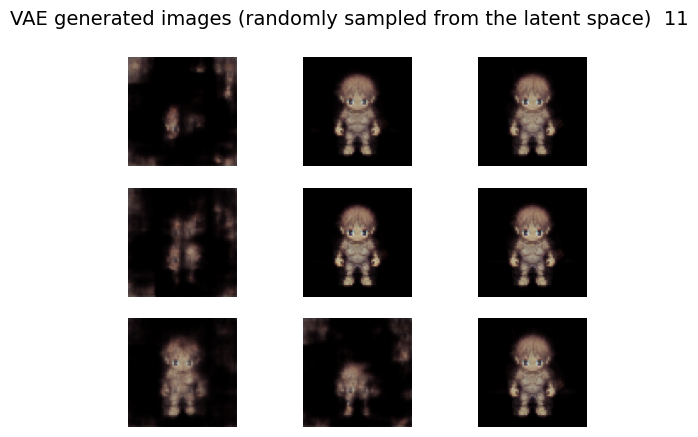

114/114 [==============================] - 2s 20ms/step - loss: 0.1576


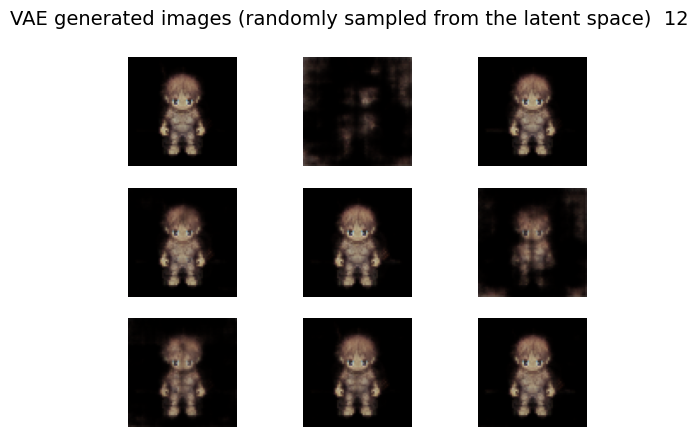

114/114 [==============================] - 2s 14ms/step - loss: 0.1574


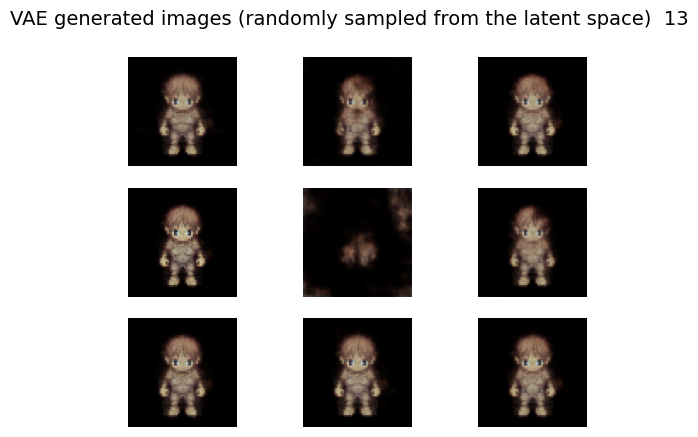

114/114 [==============================] - 1s 12ms/step - loss: 0.1571


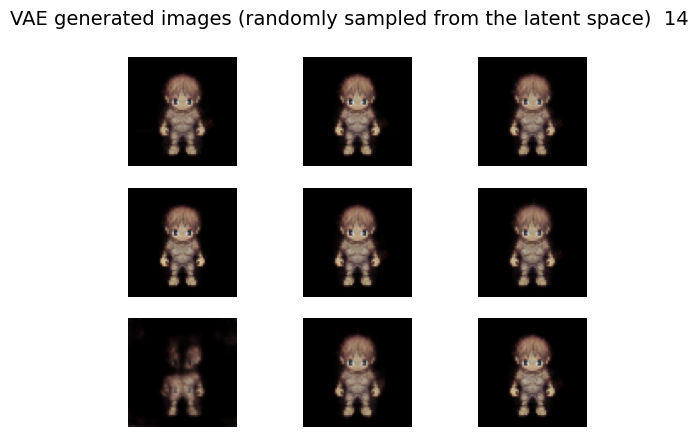

114/114 [==============================] - 1s 12ms/step - loss: 0.1571


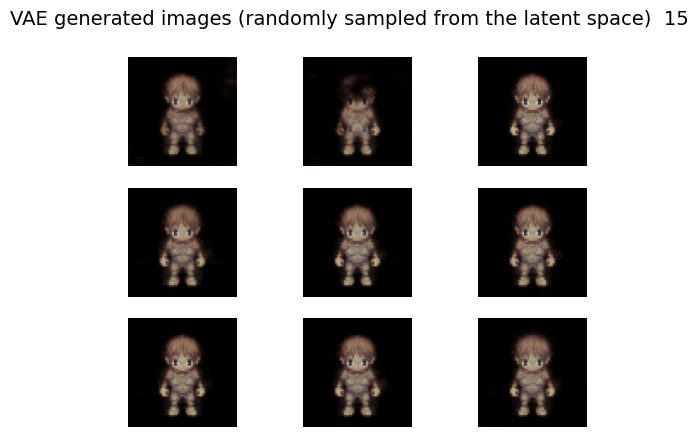

114/114 [==============================] - 1s 11ms/step - loss: 0.1570


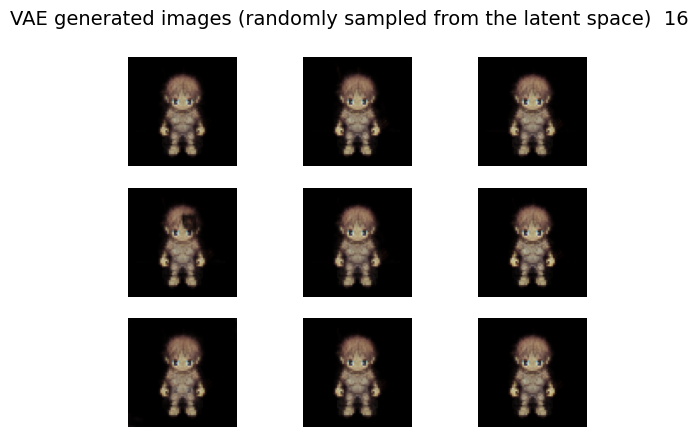

114/114 [==============================] - 1s 12ms/step - loss: 0.1568


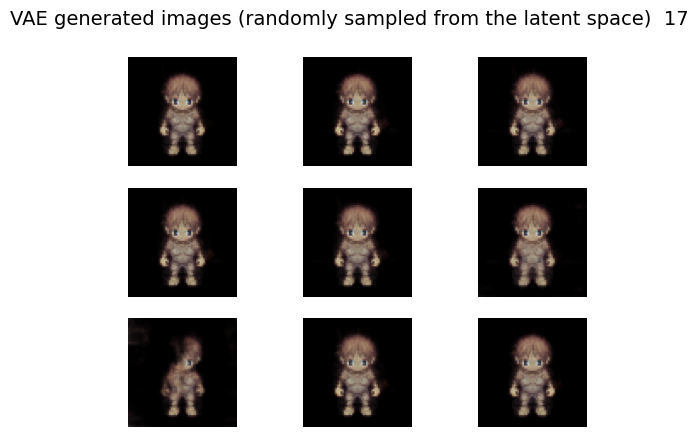

114/114 [==============================] - 2s 14ms/step - loss: 0.1569


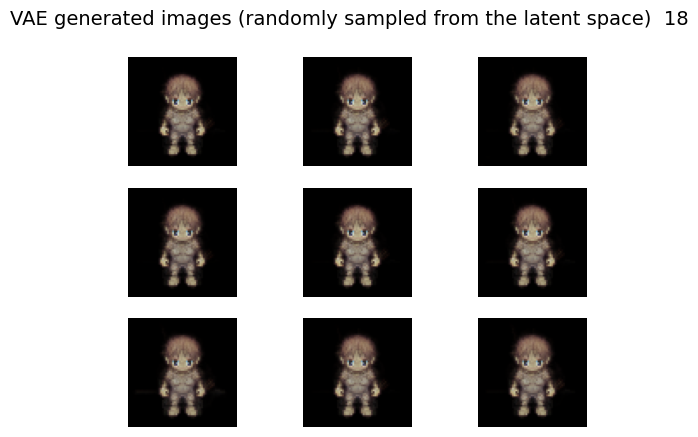

114/114 [==============================] - 2s 18ms/step - loss: 0.1566


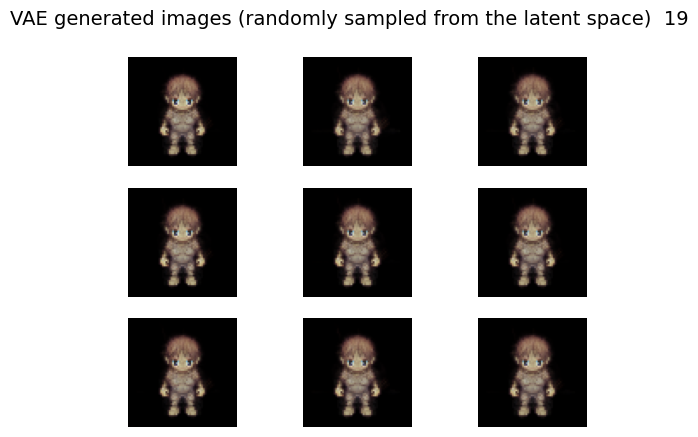

In [5]:
# Training the VAE model

latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    latent_vectors = np.random.randn(9, latent_dim)
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8)

    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

In [9]:
########################################### GAN ########################################################

from tensorflow.keras.optimizers.legacy import Adam

def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN

def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)


def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):

            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              263168    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 8, 8, 128)         73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 16, 16, 128)       147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 32, 32, 128)       147584    
 DTranspose)                                                     
                                                      

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


 14%|█▍        | 1/7 [00:03<00:20,  3.42s/it]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 2/7 [00:03<00:07,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 3/7 [00:03<00:03,  1.10it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 4/7 [00:03<00:01,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 5/7 [00:04<00:00,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6/7 [00:04<00:00,  2.77it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


1/1 [==============================] - 0s 306ms/step


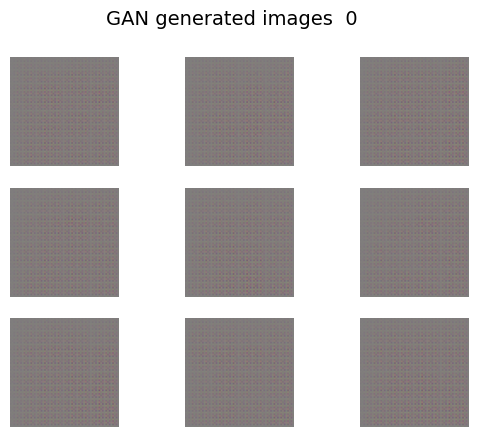

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.68it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2/7 [00:00<00:00,  7.03it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  7.01it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


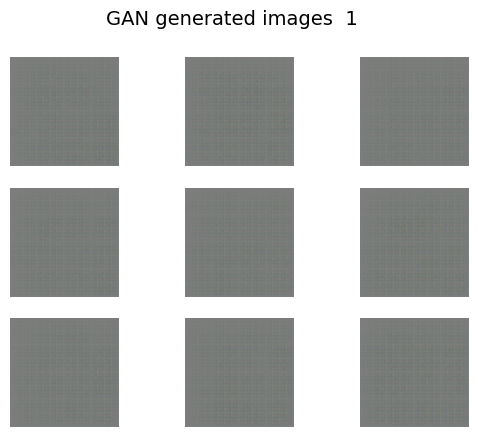

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.63it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2/7 [00:00<00:00,  7.04it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.99it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  7.05it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 7/7 [00:01<00:00,  6.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


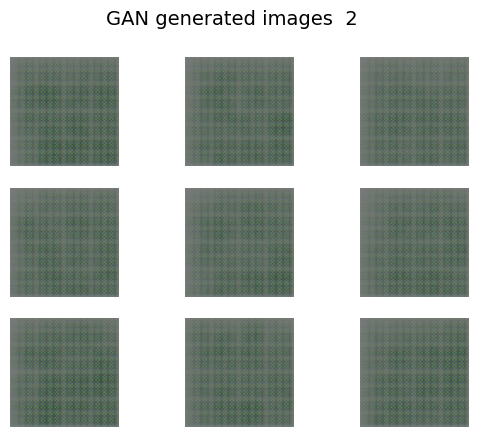

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2/7 [00:00<00:00,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.65it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.66it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


1/1 [==============================] - 0s 24ms/step


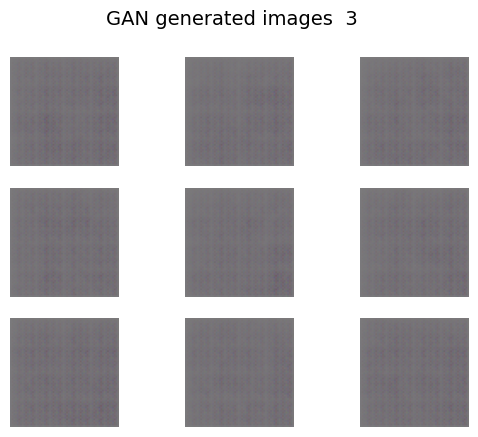

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2/7 [00:00<00:00,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.60it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.55it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


1/1 [==============================] - 0s 22ms/step


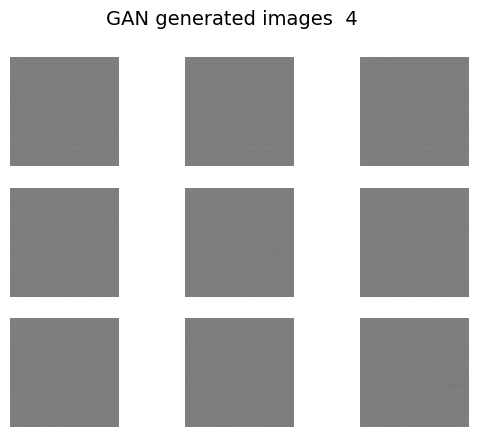

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2/7 [00:00<00:00,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.57it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.74it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


1/1 [==============================] - 0s 24ms/step


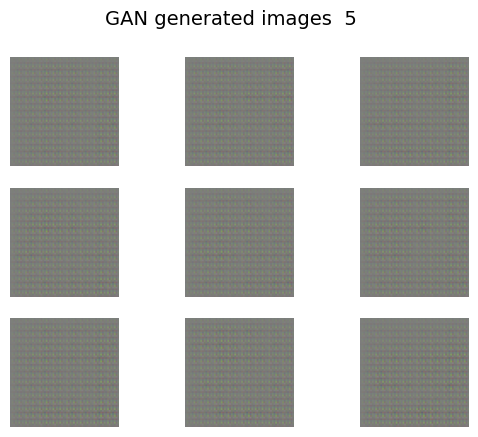

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.49it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 2/7 [00:00<00:00,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


1/1 [==============================] - 0s 24ms/step


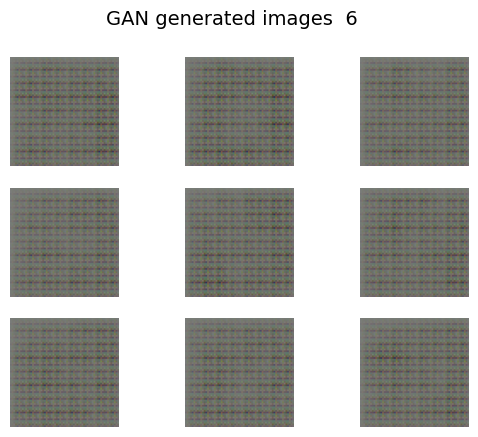

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 1/7 [00:00<00:01,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3/7 [00:00<00:00,  4.99it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 5/7 [00:01<00:00,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


1/1 [==============================] - 0s 41ms/step


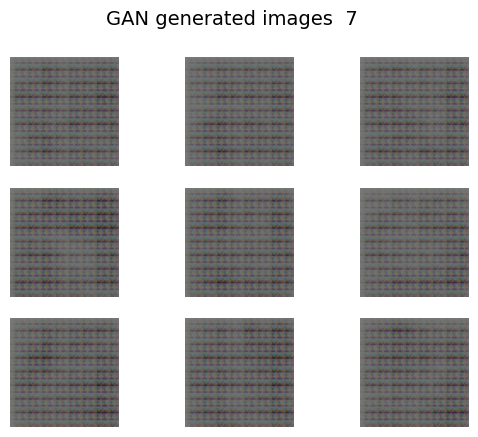

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1/7 [00:00<00:01,  3.18it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2/7 [00:00<00:01,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3/7 [00:00<00:00,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 5/7 [00:01<00:00,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.79it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


1/1 [==============================] - 0s 26ms/step


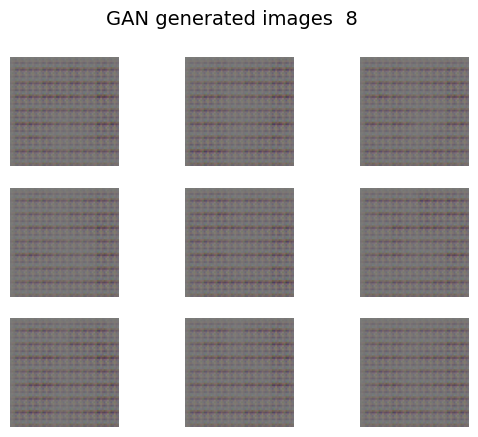

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2/7 [00:00<00:00,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 3/7 [00:00<00:00,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


1/1 [==============================] - 0s 34ms/step


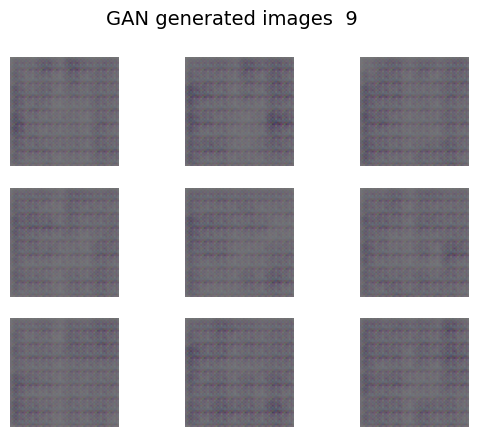

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.84it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 6/7 [00:00<00:00,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


1/1 [==============================] - 0s 28ms/step


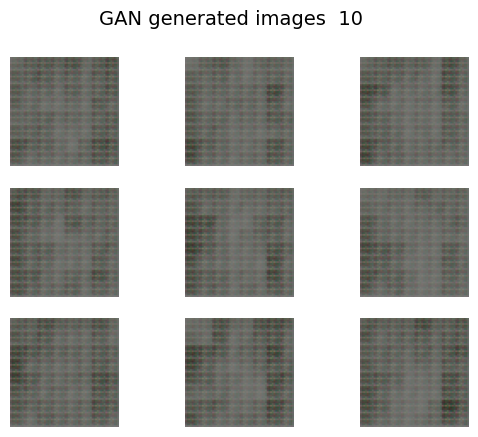

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1/7 [00:00<00:01,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


1/1 [==============================] - 0s 26ms/step


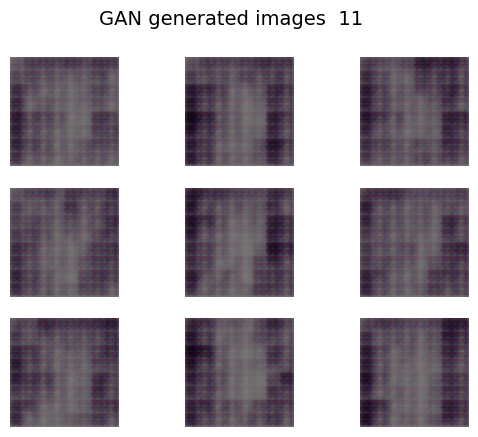

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.13it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


1/1 [==============================] - 0s 38ms/step


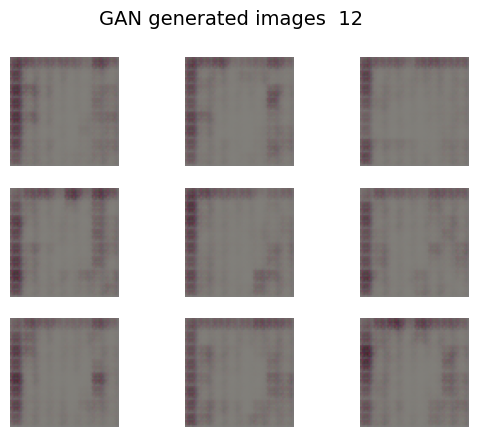

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  6.10it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


1/1 [==============================] - 0s 27ms/step


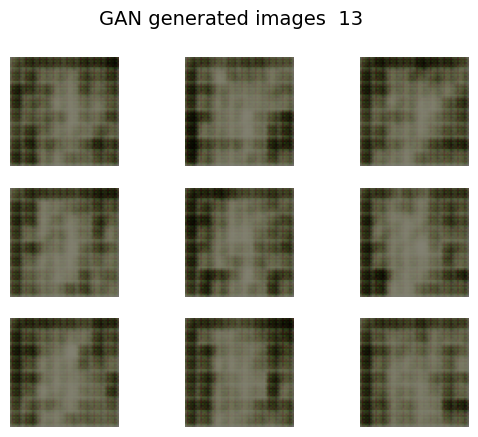

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.75it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.39it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  4.27it/s]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


1/1 [==============================] - 0s 28ms/step


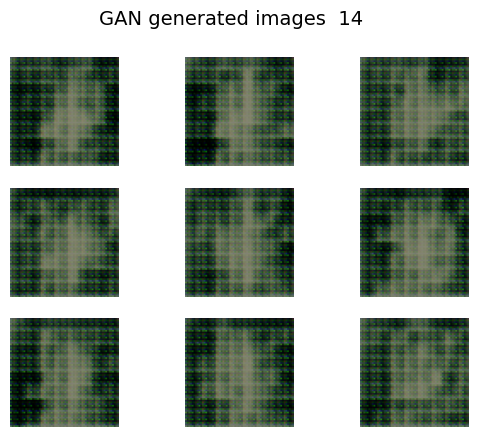

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 1/7 [00:00<00:01,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 2/7 [00:00<00:01,  3.42it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 3/7 [00:00<00:00,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 5/7 [00:01<00:00,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


1/1 [==============================] - 0s 29ms/step


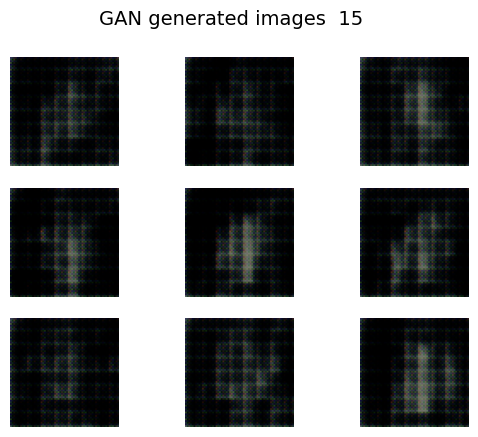

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


1/1 [==============================] - 0s 29ms/step


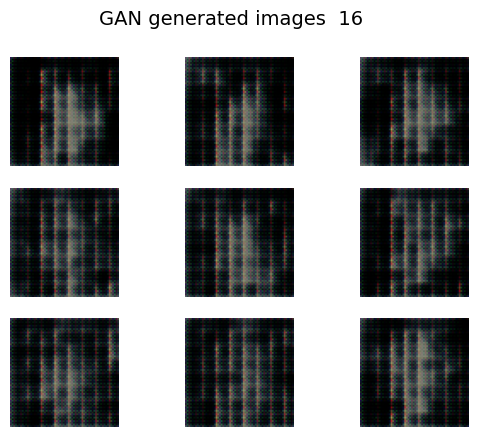

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


1/1 [==============================] - 0s 26ms/step


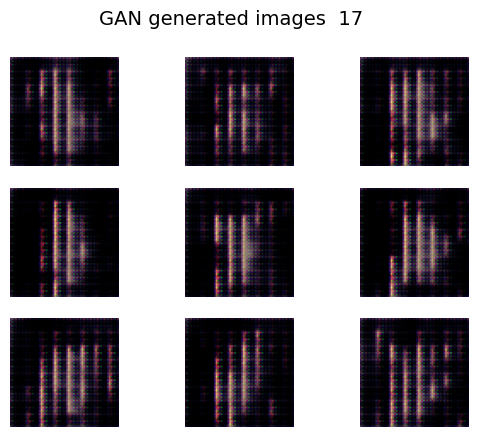

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


1/1 [==============================] - 0s 25ms/step


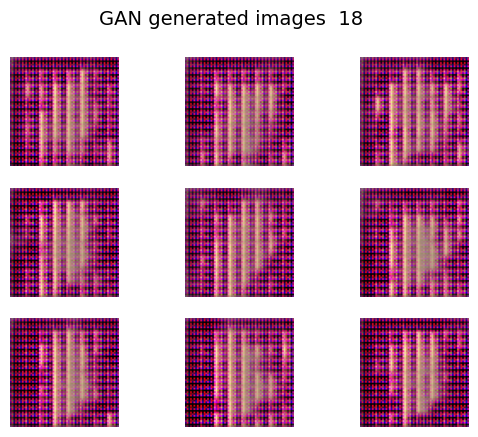

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1/7 [00:00<00:01,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2/7 [00:00<00:00,  5.76it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3/7 [00:00<00:00,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 4/7 [00:00<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 5/7 [00:00<00:00,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6/7 [00:01<00:00,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


1/1 [==============================] - 0s 26ms/step


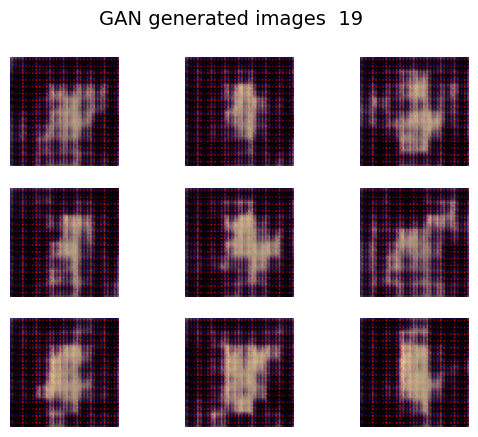

In [10]:
## Build and train the model (need around 10 epochs to start seeing some results)

latent_dim = 256
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=20)